# Clasificación para inversión usando CNN

Se cargan las imagenes generadas con su cluster correspondiente (_cluster.ipynb_) y son entrenados usando una CNN con 80% de datos de entrenamiento y 20% de prueba.

## Librerias

Pandas es usado para realizar operaciones sobre el dataframe, tensorflow se utiliza para cargar el modelo CNN, matplotlib para graficar y sklearn para crear el conjunto de entrenamiento y prueba.

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from os import listdir
from matplotlib import image

from sklearn.model_selection import train_test_split

## Validación del modelo

### Carga de las imagenes
Carga de imagenes del directorio y creacióin de dataframe para modelado.

In [44]:
moneda = 'BTC-USD'
#Ventana de tiempo: 1 para diario, 7 para semanal, 30 para mensual
window_MA = 1

#Carga de imagenes generadas
loaded_images = pd.DataFrame(columns = ['IMG','Cluster'])
img = []
label = []
for filename in listdir('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+ str(moneda) +'_'+ str(window_MA)):
    if filename == '.DS_Store':
        continue
    img_data = image.imread('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+str(moneda)+'_'+str(window_MA)+'/'+filename)
    img.append(img_data)
    label.append(filename[-5])

    
loaded_images['IMG'] = img
loaded_images['Cluster'] = label

### Creación de conjunto de entrenamiento y prueba
Se reestructuran las imagenes para el modelo de entrenamiento y se dividen los datos totales en un 20% para pruebas y 80% como conjunto de entrenamiento para evitar sobreajuste.

In [45]:
train, test = train_test_split(loaded_images, test_size=0.2)

train_img0 = np.asarray(train['IMG'])
test_img0 = np.asarray(test['IMG'])

train_img = np.arange(1024).reshape((32, 32))
test_img = np.arange(1024).reshape((32, 32))

for array in train_img0:
    train_img = np.concatenate([train_img, array])

for array in test_img0:
    test_img = np.concatenate([test_img, array])

train_img = np.delete(train_img, np.arange(32), axis=0)
test_img = np.delete(test_img, np.arange(32), axis=0)

train_img = train_img.reshape(-1,32,32,1)
test_img = test_img.reshape(-1,32,32,1)

### Agrupamiento en vender, comprar o incertidumbre

El agrupamiento correspondiente de las imagenes del conjunto de prueba son renombrados a terminos financieros para tener una clasificación clara.

In [46]:
s = pd.Series(np.arange(len(train)))
train = train.set_index(s)
j = 0

for i in train['Cluster']:
    if(i == '2' or i == '4' or i == '6' or i == '8'):
        train['Cluster'][j] = 2 #Vende
    elif(i == '3' or i == '9'):
        train['Cluster'][j] = 1 #Incertidumbre
    else:
        train['Cluster'][j] = 0 #Compra
    j = j + 1
        

s = pd.Series(np.arange(len(test)))
test = test.set_index(s)

j = 0
for i in test['Cluster']:
    if(i == '2' or i == '4' or i == '6' or i == '8' ):
        test['Cluster'][j] = 2 #Vende
    elif(i == '3'or i == '9'):
        test['Cluster'][j] = 1 #Incertidumbre
    else:
        test['Cluster'][j] = 0 #Compra
    j += 1


In [47]:
train_cluster = np.asarray(train['Cluster']).astype('uint8').reshape(-1,1)
test_cluster = np.asarray(test['Cluster']).astype('uint8').reshape(-1,1)

### Presentación de imagenes generadas

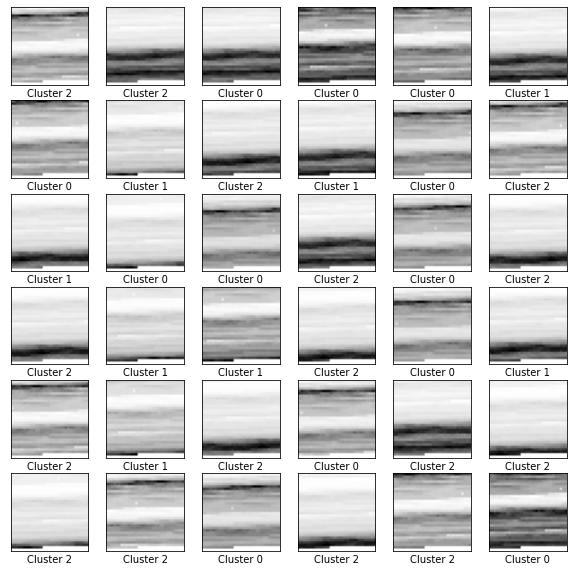

In [48]:
#class_names = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8','Cluster 9']
class_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i].reshape(32,32), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_cluster[i][0]])
plt.show()

### Creación y configuración del modelo

In [49]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [50]:
model.add(layers.Flatten())
model.add(layers.Dense(2560, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 128)       36992     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 256)       

### Entrenamiento


In [51]:
%%time
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_img, train_cluster, epochs=50,
                    validation_data=(test_img, test_cluster))

Epoch 1/50
 1/33 [..............................] - ETA: 10s - loss: 1.1015 - accuracy: 0.2188

2022-04-28 12:47:54.612547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 24ms/step - loss: 0.8112 - accuracy: 0.5788 - val_loss: 0.6082 - val_accuracy: 0.6615
Epoch 2/50
 1/33 [..............................] - ETA: 0s - loss: 0.7238 - accuracy: 0.6250

2022-04-28 12:47:55.387163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 14ms/step - loss: 0.4882 - accuracy: 0.7750 - val_loss: 0.3569 - val_accuracy: 0.8577
Epoch 3/50
33/33 [==============================] - 0s 14ms/step - loss: 0.3869 - accuracy: 0.8327 - val_loss: 0.3601 - val_accuracy: 0.8385
Epoch 4/50
33/33 [==============================] - 1s 16ms/step - loss: 0.3206 - accuracy: 0.8760 - val_loss: 0.4433 - val_accuracy: 0.8577
Epoch 5/50
33/33 [==============================] - 0s 14ms/step - loss: 0.2949 - accuracy: 0.8933 - val_loss: 0.2474 - val_accuracy: 0.9154
Epoch 6/50
33/33 [==============================] - 0s 14ms/step - loss: 0.2487 - accuracy: 0.9019 - val_loss: 0.2103 - val_accuracy: 0.9346
Epoch 7/50
33/33 [==============================] - 1s 15ms/step - loss: 0.2661 - accuracy: 0.9000 - val_loss: 0.2172 - val_accuracy: 0.9115
Epoch 8/50
33/33 [==============================] - 0s 15ms/step - loss: 0.2066 - accuracy: 0.9269 - val_loss: 0.2295 - val_accuracy: 0.9154
Epoch 9/50
33/33 [======

### Resultados del entrenamiento

9/9 - 0s - loss: 0.2249 - accuracy: 0.9500 - 86ms/epoch - 10ms/step
0.949999988079071


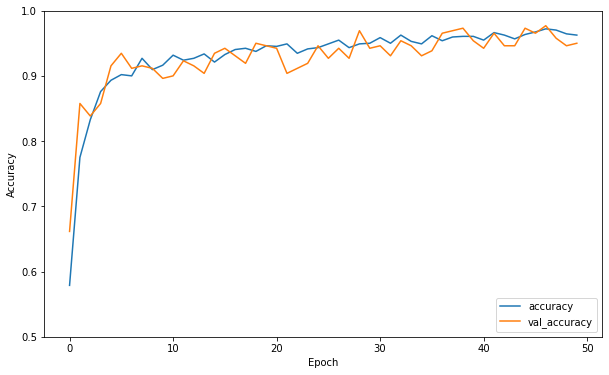

In [52]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_img,  test_cluster, verbose=2)
print(test_acc)
#model.save('CNN_'+str(moneda)+'_'+str(window_MA)+'_Sum.h5')

## Guardado del modelo

In [53]:
moneda = 'BTC-USD'
#Ventana de tiempo: 1 para diario, 7 para semanal, 30 para mensual
window_MA = 1

#Carga de imagenes generadas
loaded_images = pd.DataFrame(columns = ['IMG','Cluster'])
img = []
label = []
for filename in listdir('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+ str(moneda) +'_'+ str(window_MA)):
    if filename == '.DS_Store':
        continue
    img_data = image.imread('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+str(moneda)+'_'+str(window_MA)+'/'+filename)
    img.append(img_data)
    label.append(filename[-5])

    
loaded_images['IMG'] = img
loaded_images['Cluster'] = label

train = loaded_images

train_img0 = np.asarray(train['IMG'])
train_img = np.arange(1024).reshape((32, 32))

for array in train_img0:
    train_img = np.concatenate([train_img, array])

train_img = np.delete(train_img, np.arange(32), axis=0)
train_img = train_img.reshape(-1,32,32,1)

s = pd.Series(np.arange(len(train)))
train = train.set_index(s)
j = 0

for i in train['Cluster']:
    if(i == '2' or i == '4' or i == '6' or i == '8'):
        train['Cluster'][j] = 2 #Vende
    elif(i == '3' or i == '9'):
        train['Cluster'][j] = 1 #Incertidumbre
    else:
        train['Cluster'][j] = 0 #Compra
    j = j + 1
        

train_cluster = np.asarray(train['Cluster']).astype('uint8').reshape(-1,1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_img, train_cluster, epochs=50)
print("Modelo guardado.")
model.save('CNN_'+str(moneda)+'_'+str(window_MA)+'_Sum.h5')

Epoch 1/50
 4/41 [=>............................] - ETA: 0s - loss: 0.2312 - accuracy: 0.9844 

2022-04-28 12:48:28.275480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 17ms/step - loss: 0.1293 - accuracy: 0.9562
Epoch 2/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1090 - accuracy: 0.9585
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0961 - accuracy: 0.9654
Epoch 4/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0949 - accuracy: 0.9569
Epoch 5/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0881 - accuracy: 0.9623
Epoch 6/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0867 - accuracy: 0.9623
Epoch 7/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1061 - accuracy: 0.9546
Epoch 8/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0839 - accuracy: 0.9631
Epoch 9/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0822 - accuracy: 0.9669
Epoch 10/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0844 - accuracy: 0.9677
Epoch 11/50
41/41 [=